Before you run this on Colab you have to move the 'CNN-DiseaseDet..' folder to your google drive or clone the Githup repo to the drive

In [ ]:
#!pip install tensorflow

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

You have to allow colab access to your google drive

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix
from numpy.random import seed


In [ ]:
seed(1)
tf.random.set_seed(2)

In [ ]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "./PlantImgData"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
256/32

In [ ]:
def dataset_splitting(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)

In [ ]:
train_data, val_data, test_data = dataset_splitting(dataset)

In [ ]:
test_data

In [ ]:
print(train_data)

In [ ]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch)
  break

In [ ]:
train_data

In [ ]:
# caching,shuffle and prefetching the data
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

The Model

In [ ]:
# Data augmentation by flipping and rotating existing images
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.5)
])

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [ ]:
# Creating Convolution layer 
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax'),

])


model.build(input_shape = input_shape)

In [ ]:
model.summary()

In [ ]:
# Optimizing the model 'SparseCategoricalCrossentropy'=>as there are many categorical classes of data
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history = model.fit(
train_data, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = 1, validation_data = val_data)

In [ ]:
scores = model.evaluate(train_data)

In [ ]:
scores1 = model.evaluate(test_data)

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
# Getting the model history to analyse
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

In [ ]:
print(val_acc)

In [ ]:
#graphs for accuracy and loss of training and validation data
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.plot(range(EPOCHS), train_acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy') 

plt.subplot(2,3,2)
plt.plot(range(EPOCHS), train_loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

In [ ]:
for images_batch, labels_batch in test_data.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_labels = labels_batch[0].numpy()
    print('First image to predict')
    plt.imshow(first_image)
    print("First image's true label", first_labels)
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])

In [ ]:
len(test_data)

In [ ]:
predictions = model.predict(x=test_data, batch_size=32, verbose=1)
pred = np.argmax(predictions, axis=1)
y = np.concatenate([y for x, y in test_data], axis=0)
cm = confusion_matrix(y_true=y, y_pred = pred)
cm

In [ ]:
y = np.concatenate([y for x, y in test_data], axis=0)
y

In [ ]:
pred

In [ ]:
predictions = model.predict(x=test_data, batch_size=32, verbose=1)


In [ ]:
score = tf.nn.softmax(predictions)
score

In [ ]:
predictions[0]

In [ ]:
predictions

In [ ]:
pred = np.argmax(predictions, axis=1)
pred

In [ ]:
print(test_data)

In [ ]:
y = np.concatenate([y for x, y in test_data], axis=0)
y

In [ ]:
y

In [ ]:
for images, labels in test_data:
    print(labels.numpy())

In [ ]:
actual = []
pred = []

for images, labels in test_data:
    predicted_class, confidence = predict(model, images.numpy())
    pred.append(predicted_class)
    print(pred)
        
    # actual_class = class_names[labels[i]] 
    # plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    # plt.axis("off")

In [ ]:
# to get predictions for all test data points
probs = model.predict(test_data)
# to get labels for all the test data points
y_test = test_data.labels.numpy()

In [ ]:
cm = confusion_matrix(y_true=y, y_pred = pred)
cm

In [ ]:
#plotting image
for batch_image, batch_label in train_data.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = class_names[batch_label[0]]
    
    print('First Image of batch to predict :')
    plt.imshow(first_image)
    print('Actual label : ', first_label)
    
    batch_prediction = model.predict(batch_image)
    print('Predicted label : ', class_names[np.argmax(batch_prediction[0])])
    plt.axis('off')

In [ ]:
# plotting batch of images with its actual label, predicted label and confidence
plt.figure(figsize = (16,16))
for batch_image, batch_label in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_names[batch_label[i]]
        plt.imshow(image)
    
        batch_prediction = model.predict(batch_image)
        predicted_class = class_names[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    
        plt.axis('off')

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
pred = []
act = []
w_picture=[]
right_pred = 0
false_pred = 0
lab = []
pict_lab = []

for images, labels in test_data:
    print('new______________________')
    
    for i in range(32):
        lab = []
        predicted_class, confidence = predict(model, images[i].numpy())
        #print(type(predicted_class))        
        if predicted_class == 'Potato___healthy':
            pred.append(2)
            # print(2)
        elif predicted_class == 'Potato___Late_blight':
            pred.append(1)
            # print(1)
        elif predicted_class == 'Potato___Early_blight':
            pred.append(0)
            # print(0)
            
        actual_class = class_names[labels[i]]
        
        if actual_class == 'Potato___healthy':
            act.append(2)
            # print(2)
        elif actual_class == 'Potato___Late_blight':
            act.append(1)
            # print(1)
        elif actual_class == 'Potato___Early_blight':
            act.append(0)
            # print(0)
            
        if actual_class == predicted_class:
            right_pred += 1
        else:
            false_pred += 1
            w_picture.append(images[0].numpy().astype('uint8'))
            lab.append(predicted_class)
            lab.append(actual_class)
            lab.append(confidence)
            pict_lab.append(lab)
            
        
print(right_pred)
print(false_pred)
print(right_pred + false_pred)       
print(pred)
print(act)



In [520]:
right_pred = 253
false_pred = 3

<AxesSubplot:>

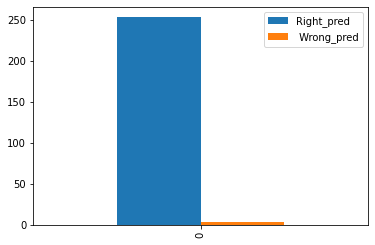

In [521]:
N=2
# y= pd.DataFrame[right_pred, false_pred]
# x=[1,2]
# ax = plt.gca()
# ax.axes.xaxis.set_visible(False)
# ind = np.arange(N)
# ax.set_xticks(ind, labels=['Right_Pred', 'Wrong_Pred'])
#y.plot.bar
data={'Right_pred':[right_pred],' Wrong_pred':[false_pred]}

df=pd.DataFrame(data)
df.plot.bar(x=None, y=None)

In [ ]:
pict_lab

AxesImage(144,757.948;262.588x255.812)
AxesImage(459.106,757.948;262.588x255.812)
AxesImage(774.212,757.948;262.588x255.812)
AxesImage(144,450.974;262.588x255.812)


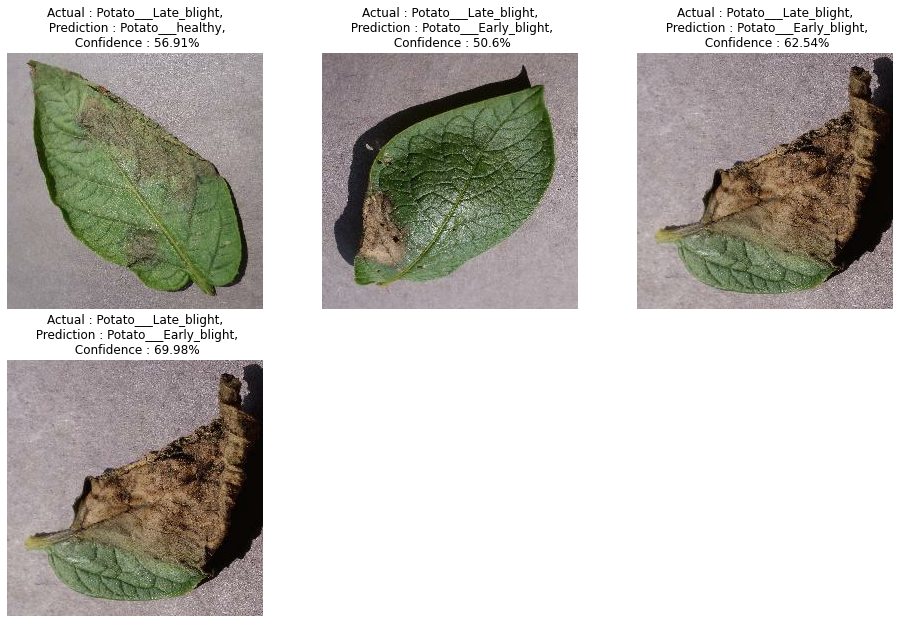

In [519]:
plt.figure(figsize = (16,16))
for i in range (len(w_picture)):
    ax = plt.subplot(3,3,i+1)
    print(plt.imshow(w_picture[i]))
    plt.title(f'Actual : {pict_lab[i][1]},\n Prediction : {pict_lab[i][0]},\n Confidence : {pict_lab[i][2]}%')
    plt.axis('off')

In [ ]:
class_names

In [ ]:
plt.figure(figsize=(15, 15))
pred = []
act = []
for images, labels in test_data.take(8):
    for i in range(32):
        # ax = plt.subplot(3, 3, i + 1)
        # plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        print(predicted_class)
        pred.append(predicted_class)
        print(len(pred))
        
        actual_class = class_names[labels[i]]
        print(actual_class)
        # plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        # plt.axis("off")

In [ ]:
model_version = max([int(i) for i in (os.listdir("../CNN-DiseaseDetectionOnPlantLeaves/models")+[0])]) + 1
model.save(f"../CNN-DiseaseDetectionOnPlantLeaves/models/{model_version}")